In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [4]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [5]:
# data load
df_name = 'freesolv'
df = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name + '.csv')

smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['CN(C)C(=O)c1ccc(cc1)OC', 'CS(=O)(=O)Cl', 'CC(C)C=C', 'CCc1cnccn1', 'CCCCCCCO']
0   -11.01
1    -4.87
2     1.83
3    -5.45
4    -4.21
Name: freesolv, dtype: float64


In [6]:
# 분자 특성 추출 class
class MolecularFeatureExtractor:
    def __init__(self):
        self.descriptors = [desc[0] for desc in Descriptors._descList]

    def extract_molecular_features(self, smiles_list):
        features_dict = {desc: [] for desc in self.descriptors}

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                for descriptor_name in self.descriptors:
                    descriptor_function = getattr(Descriptors, descriptor_name)
                    try:
                        features_dict[descriptor_name].append(descriptor_function(mol))
                    except:
                        features_dict[descriptor_name].append(None)
            else:
                for descriptor_name in self.descriptors:
                    features_dict[descriptor_name].append(None)

        return pd.DataFrame(features_dict)

In [7]:
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,11.429183,0.002457,11.429183,0.002457,0.686360,179.219,166.115,179.094629,70,0,...,0,0,0,0,0,0,0,0,0,-11.01
1,9.397377,-3.194444,9.397377,0.925154,0.421427,114.553,111.529,113.954228,32,0,...,0,0,0,0,0,0,0,0,0,-4.87
2,3.560185,0.648148,3.560185,0.648148,0.412737,70.135,60.055,70.078250,30,0,...,0,0,0,0,0,0,0,0,0,1.83
3,4.034722,0.966111,4.034722,0.966111,0.536795,108.144,100.080,108.068748,42,0,...,0,0,0,0,0,0,0,0,0,-5.45
4,8.365587,0.364796,8.365587,0.364796,0.544191,116.204,100.076,116.120115,50,0,...,0,0,0,0,0,0,0,3,0,-4.21


In [24]:
# 컬럼 순서 변경
# target을 가장 앞으로
cols = df_all_features.columns.tolist()
df_all_features = df_all_features[[cols[-1]] + cols[:-1]]
print(df_all_features)

     target  MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  \
0    -11.01       11.429183        0.002457          11.429183   
1     -4.87        9.397377       -3.194444           9.397377   
2      1.83        3.560185        0.648148           3.560185   
3     -5.45        4.034722        0.966111           4.034722   
4     -4.21        8.365587        0.364796           8.365587   
..      ...             ...             ...                ...   
637   -2.04       10.622272       -0.081946          10.622272   
638   -5.48        3.222222        1.250000           3.222222   
639   -8.83       10.036149        0.181111          10.036149   
640    0.29        5.480456        0.837018           5.480456   
641   -5.06        4.944444        0.777778           4.944444   

     MinAbsEStateIndex       qed    MolWt  HeavyAtomMolWt  ExactMolWt  \
0             0.002457  0.686360  179.219         166.115  179.094629   
1             0.925154  0.421427  114.553         111.529  11

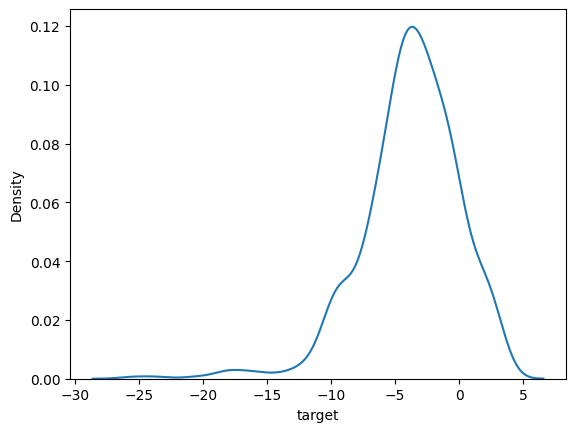

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.kdeplot(df.iloc[:, -1],color='blue', fill = True)
# plt.ylabel('')
sns.kdeplot(df_all_features['target'])
plt.show()


In [52]:
print(df_all_features['target'].value_counts())
print(df_all_features['target'].describe().T)

target
-2.49    6
-3.88    5
-0.90    4
-4.42    4
-3.64    4
        ..
-3.41    1
-1.69    1
-2.94    1
 1.79    1
-5.06    1
Name: count, Length: 486, dtype: int64
count    642.000000
mean      -3.803006
std        3.847820
min      -25.470000
25%       -5.727500
50%       -3.530000
75%       -1.215000
max        3.430000
Name: target, dtype: float64


In [28]:
# 통계량
df_static = df_all_features.describe().T

# overleaf 양식에 맞게 통계량 출력
for i in range(len(df_static)):
    print(f'{df_static.iloc[i].name.replace("_", "")} & {df_static.iloc[i]["mean"]:.2f} & {df_static.iloc[i]["std"]:.2f} & {df_static.iloc[i]["min"]:.2f} & {df_static.iloc[i]["25%"]:.2f} & {df_static.iloc[i]["50%"]:.2f} & {df_static.iloc[i]["75%"]:.2f} & {df_static.iloc[i]["max"]:.2f} \\\\')

target & -3.80 & 3.85 & -25.47 & -5.73 & -3.53 & -1.21 & 3.43 \\
MaxEStateIndex & 6.91 & 3.36 & 0.00 & 3.83 & 6.16 & 10.05 & 13.97 \\
MinEStateIndex & 0.11 & 1.36 & -5.97 & -0.25 & 0.36 & 0.95 & 4.00 \\
MaxAbsEStateIndex & 6.91 & 3.36 & 0.00 & 3.83 & 6.16 & 10.05 & 13.97 \\
MinAbsEStateIndex & 0.67 & 0.62 & 0.00 & 0.20 & 0.54 & 1.04 & 5.97 \\
qed & 0.49 & 0.10 & 0.24 & 0.43 & 0.49 & 0.55 & 0.89 \\
MolWt & 138.95 & 72.70 & 16.04 & 94.12 & 120.88 & 159.70 & 498.66 \\
HeavyAtomMolWt & 129.51 & 72.60 & 12.01 & 84.08 & 112.09 & 150.09 & 498.66 \\
ExactMolWt & 138.59 & 72.25 & 16.03 & 94.00 & 120.57 & 159.60 & 493.69 \\
NumValenceElectrons & 49.00 & 21.46 & 8.00 & 36.00 & 44.00 & 58.00 & 132.00 \\
NumRadicalElectrons & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
MaxPartialCharge & 0.13 & 0.14 & -0.34 & 0.01 & 0.10 & 0.25 & 0.56 \\
MinPartialCharge & -0.28 & 0.15 & -0.51 & -0.40 & -0.30 & -0.10 & -0.05 \\
MaxAbsPartialCharge & 0.29 & 0.15 & 0.05 & 0.12 & 0.32 & 0.41 & 0.56 \\
MinAbsPart

In [9]:
# # 시각화
# # 밀도 함수
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.kdeplot(df.iloc[:, -1],color='blue', fill = True)
# plt.ylabel('')

# plt.savefig(f'density_{df_name}.png', dpi = 300, bbox_inches = 'tight')
# plt.show()

In [10]:
# # 박스플랏
# plt.boxplot(df.iloc[:, -1],  vert=False)

# plt.savefig(f'boxplot_{df_name}.png', dpi = 300, bbox_inches = 'tight')
# plt.show()